# Hierarchical Graph Representation Learning with Differentiable Pooling

<img src="static/diffpool.png" alt="Diffpool" width="800" />

Links to the original paper:
* ArXiv: <https://arxiv.org/abs/1806.08804>
* Code Repository: <https://github.com/RexYing/diffpool>

## Toy Example: 1-Layer Diffpool

In the following cells the mathematical formulas of Difffpool are explained with a small example.

Consider a small graph with 5 nodes, 5 edges and each node has two features. In this example we use a one layer Diffpool model to reduce this graph to 2 clusters with new aggregated embeddings. As GNNs we use GraphSAGE for both the embedding and pooling models.

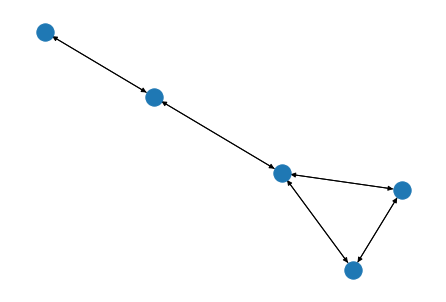

In [1]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
import dgl

from dgl_layers.model import DiffPool

nx_G = nx.Graph()
nx_G.add_edges_from([(1, 2), (2, 3), (3, 4), (3, 5), (4, 5)])

g = dgl.from_networkx(nx_G)
X = th.randn(5, 2)

nx.draw(dgl.to_networkx(g))
plt.show()

### Compute cluster assignments & node embeddings

The first step is to compute the cluster assignments and associated embeddings of the aggregated nodes. We simply apply the formulas provided in the paper:

\begin{align*}
Z = \mathrm{GNN}_{\mathrm{embed}}(A, X) \\
S = \mathrm{softmax}(\mathrm{GNN}_{\mathrm{pool}}(A, X))
\end{align*}

In [2]:
from dgl.nn.pytorch import DenseSAGEConv
from torch.nn.functional import softmax

embed = DenseSAGEConv(2, 2, norm=nn.BatchNorm1d(2))
pool = DenseSAGEConv(2, 2, norm=nn.BatchNorm1d(2))

A = g.adj().to_dense()
Z = embed(A, X)
S = softmax(pool(A, X), dim=-1)

Z, S

(tensor([[-1.7326,  0.3896],
         [ 0.1142,  1.6053],
         [-0.3214, -1.4580],
         [ 0.9699, -0.2684],
         [ 0.9699, -0.2684]], grad_fn=<NativeBatchNormBackward0>),
 tensor([[0.4822, 0.5178],
         [0.8398, 0.1602],
         [0.1732, 0.8268],
         [0.4972, 0.5028],
         [0.4972, 0.5028]], grad_fn=<SoftmaxBackward0>))

### Construct the new representation graph

In the second step we now have to construct the new graph. To do so, we first calculate the embeddings $X'$ for each cluster and then the new adjacency matrix $A'$ that connects the clusters.

Again, we simply use the formulas from the paper in our example:

\begin{align*}
X' = S^T Z \\
A' = S^T A S
\end{align*}

In [3]:
X_new = S.transpose(-1, -2) @ Z
A_new = S.transpose(-1, -2) @ A @ S

X_new, A_new

(tensor([[ 0.1693,  1.0165],
         [-0.1693, -1.0165]], grad_fn=<MmBackward0>),
 tensor([[1.9397, 2.7305],
         [2.7305, 2.5992]], grad_fn=<MmBackward0>))

Finally, we can take a look at the new graph. As already announced, we now have only two nodes that are connected by weighted edges and contain the embeddings from the nodes combined in them representatively in their new embeddings.

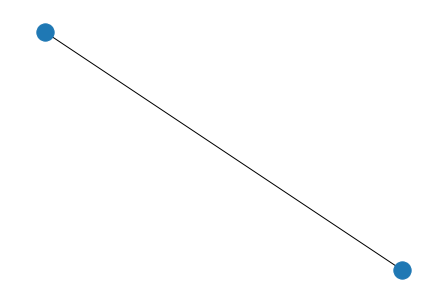

In [4]:
g_new = nx.from_numpy_matrix(A_new.detach().numpy(), create_using=nx.Graph)
g_new.remove_edges_from(nx.selfloop_edges(g_new))
nx.draw(g_new)
plt.show()

## Diffpool in practice: Graph classification of the ENZYMES datasets

In [5]:
import dgl
import torch.nn.functional as F
from dgl.data import tu
import torch.utils.data

dataset = tu.LegacyTUDataset(name="PTC_FM")
train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(len(dataset) - train_size - test_size)

batch_size = 20

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(
    dataset, (train_size, val_size, test_size))
train_dataloader = dgl.dataloading.GraphDataLoader(dataset_train, batch_size=batch_size)
val_dataloader = dgl.dataloading.GraphDataLoader(dataset_val, batch_size=batch_size)
test_dataloader = dgl.dataloading.GraphDataLoader(dataset_test, batch_size=batch_size)

input_dim, label_dim, max_num_node = dataset.statistics()

Extracting file to /home/kinaan/.dgl/PTC_FM
No Node Attribute Data


In [6]:
hidden_dim = 64
embedding_dim = 64
pool_ratio = 0.25

assign_dim = int(max_num_node * pool_ratio)
activation = F.relu

In [7]:
from dgl_layers.model import DiffPool

model = DiffPool(input_dim, label_dim, max_num_node)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()
    loss_all = 0

    for data in train_dataloader:
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj, data.mask)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(dataset_train)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += int(pred.eq(data.y.view(-1)).sum())
    return correct / len(loader.dataset)


best_val_acc = test_acc = 0
for epoch in range(1, 151):
    train_loss = train(epoch)
    val_acc = test(val_dataloader)
    if val_acc > best_val_acc:
        test_acc = test(test_dataloader)
        best_val_acc = val_acc
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

AttributeError: 'list' object has no attribute 'x'